## Use Case 3: Comparing BMI above and below 25 across the proteomics data

These are the tools we will use to play with the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

This is the data we will be playing with

In [2]:
import CPTAC

Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Data...

 ******PLEASE READ******


Use case 3: BMI above and below 25
The first step is to load the clinical dataframe and the dataframe to compare it with

In [3]:
clinical = CPTAC.get_clinical()
proteomics = CPTAC.get_proteomics()

Next we will use the compare_clinical() function to create a dataframe that appends a column from the clinical dataframe to our chosen dataframe

In [4]:
bmiProt = CPTAC.compare_clinical(clinical, proteomics, 'BMI')
print(bmiProt)

        BMI  A1BG   A2M  A2ML1  A4GALT  AAAS  AACS  AADAT  AAED1  AAGAB  ...   \
idx                                                                      ...    
S001  38.88 -1.01 -0.81  -0.28    0.24  0.29  0.68   1.27  -0.33   0.27  ...    
S002  39.76 -0.51 -1.00  -0.99    1.50  0.18  0.37   1.26   0.15   1.34  ...    
S003  51.19 -0.56 -1.33   0.64     NaN -0.26  1.05  -0.10  -0.14   0.46  ...    
S004  32.69 -1.53 -1.19  -0.49    0.26 -0.03  0.77   1.10  -0.93   0.26  ...    
S005  20.28 -0.16  0.09   0.01    0.34  0.51 -0.05  -1.18    NaN   0.66  ...    
S006  55.67 -1.03 -0.63  -0.04   -0.25 -0.09 -0.11   0.85   1.27   0.17  ...    
S007  25.68 -1.09 -0.60  -1.11    0.02  0.16  0.67  -0.37  -0.12   0.33  ...    
S008  21.57 -0.29  0.51  -0.51     NaN  0.46  0.05  -0.22   0.18   0.11  ...    
S009  34.26 -0.93 -1.28   0.67    0.43 -0.05  0.86  -0.22    NaN  -0.21  ...    
S010  36.57 -0.44 -0.87   2.83   -0.32  0.18  0.47  -0.15  -0.83  -0.01  ...    
S011  27.83 -0.13  0.03   0.

Now we can split the bmiCNA dataframe into two dataframes based on whether the patient has a BMI (or whatever variable was specified in the previous step) above or below 25.
This is done by using the dataframe logic to create an array of boolean values, which we can then use to select the respective dataframes

In [5]:
greaterBool = bmiProt['BMI'] >= 25
lessBool = bmiProt['BMI'] < 25

largerThan25 = bmiProt[greaterBool]
smallerThan25 = bmiProt[lessBool]
print(largerThan25)
print(smallerThan25)

        BMI  A1BG   A2M  A2ML1  A4GALT  AAAS  AACS  AADAT  AAED1  AAGAB  ...   \
idx                                                                      ...    
S001  38.88 -1.01 -0.81  -0.28    0.24  0.29  0.68   1.27  -0.33   0.27  ...    
S002  39.76 -0.51 -1.00  -0.99    1.50  0.18  0.37   1.26   0.15   1.34  ...    
S003  51.19 -0.56 -1.33   0.64     NaN -0.26  1.05  -0.10  -0.14   0.46  ...    
S004  32.69 -1.53 -1.19  -0.49    0.26 -0.03  0.77   1.10  -0.93   0.26  ...    
S006  55.67 -1.03 -0.63  -0.04   -0.25 -0.09 -0.11   0.85   1.27   0.17  ...    
S007  25.68 -1.09 -0.60  -1.11    0.02  0.16  0.67  -0.37  -0.12   0.33  ...    
S009  34.26 -0.93 -1.28   0.67    0.43 -0.05  0.86  -0.22    NaN  -0.21  ...    
S010  36.57 -0.44 -0.87   2.83   -0.32  0.18  0.47  -0.15  -0.83  -0.01  ...    
S011  27.83 -0.13  0.03   0.61    2.03 -0.10  1.34    NaN  -0.87   0.26  ...    
S012  34.84  1.55  1.67   0.43    0.70 -0.56  1.14    NaN    NaN   0.31  ...    
S013  68.39 -0.03  0.14   2.

We can now apply the mean() function to these two dataframes to produce an array of mean values for each column in our dataframe (e.g. each gene)

In [6]:
largerMean = largerThan25.mean()
smallerMean = smallerThan25.mean()
print(largerMean)
print(smallerMean)

BMI         36.335618
A1BG        -0.155393
A2M         -0.175506
A2ML1        0.570972
A4GALT       0.079153
AAAS         0.023933
AACS         0.327191
AADAT        0.197683
AAED1       -0.147949
AAGAB        0.185393
AAK1        -0.106517
AAMDC       -0.163258
AAMP        -0.037978
AAR2        -0.108427
AARS         0.008090
AARS2       -0.023933
AARSD1      -0.045618
AASDHPPT    -0.087753
AASS        -0.310000
AATF         0.101011
ABAT        -0.140449
ABCA8       -0.285846
ABCB1       -0.261124
ABCB10       0.068202
ABCB6        0.048539
ABCB7        0.094382
ABCB8        0.042921
ABCC1        0.175955
ABCC10       0.035172
ABCC3        0.111461
              ...    
ZNF777      -0.077015
ZNF787       0.077191
ZNF8        -0.067037
ZNF800       0.139551
ZNF827      -0.042360
ZNF830      -0.138539
ZNFX1       -0.014831
ZNHIT1       0.025281
ZNHIT2       0.052619
ZNHIT3       0.097381
ZNHIT6       0.059101
ZNRD1       -0.022976
ZNRF1        0.036393
ZNRF2        0.236404
ZPR1      

Now we subtract one dataframe from the other and take the absolute value

We should also get ride of the BMI value, as a mean difference for the BMI has no meaning here (this can be done in previous steps with both dataframes if you prefer)

In [7]:
difference = abs(largerMean - smallerMean)

difference = difference[1:]
print(difference)

A1BG        0.109152
A2M         0.231869
A2ML1       1.067222
A4GALT      0.000847
AAAS        0.169704
AACS        0.009009
AADAT       0.096683
AAED1       0.266838
AAGAB       0.089152
AAK1        0.064392
AAMDC       0.208560
AAMP        0.074341
AAR2        0.172972
AARS        0.062819
AARS2       0.127569
AARSD1      0.045291
AASDHPPT    0.019520
AASS        0.412727
AATF        0.213534
ABAT        0.261359
ABCA8       0.124154
ABCB1       0.027967
ABCB10      0.008202
ABCB6       0.498733
ABCB7       0.041982
ABCB8       0.049285
ABCC1       0.073136
ABCC10      0.156284
ABCC3       0.288539
ABCC4       0.178519
              ...   
ZNF777      0.075904
ZNF787      0.039173
ZNF8        0.037946
ZNF800      0.342268
ZNF827      0.058550
ZNF830      0.035812
ZNFX1       0.063922
ZNHIT1      0.024372
ZNHIT2      0.008381
ZNHIT3      0.039619
ZNHIT6      0.095444
ZNRD1       0.136613
ZNRF1       0.177643
ZNRF2       0.045414
ZPR1        0.004331
ZRANB2      0.109111
ZRSR2       0

The final step is to create a histogram of our mean difference values

C:\Users\David\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


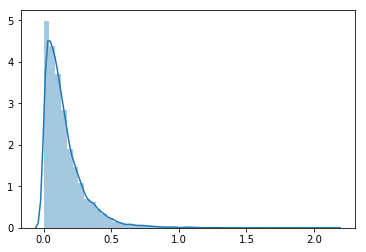

In [8]:
#TODO is this the plot we want?
sns.distplot(difference, kde=True)
plt.show()